<a href="https://colab.research.google.com/github/AbuNuurah/Ede-indigenous-man/blob/master/20_05_22_LSTM_GRU_KOSPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DATA

## ANALYSIS

In [ ]:
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential  
from keras.layers import Dense  
from keras.layers import LSTM  
from keras.layers import GRU
from keras.layers import Dropout
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import time

Using TensorFlow backend.


In [ ]:
# 같은 결과를 나오게 하기 위해 seed 설정
np.random.seed(111)

### 데이터 불러오기

In [ ]:
import datetime
from datetime import date

In [ ]:
dataset = pd.read_csv(r'KOSPI_2000.csv', encoding = 'EUC-KR')  

In [ ]:
index = dataset['Date']

In [ ]:
for i in range(len(index)):
    index[i] = datetime.datetime.strptime(index[i], "%Y.%m.%d").date()

C:\Users\K.N.W\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5010 entries, 0 to 5009
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     5010 non-null   object 
 1   Cost     5010 non-null   float64
 2   Rate     5010 non-null   float64
 3   Percent  5010 non-null   object 
 4   Amount   5010 non-null   int64  
 5   Money    5008 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 235.0+ KB


In [ ]:
dataset2 = dataset.set_index("Date")

In [ ]:
dataset2 = pd.DataFrame(dataset2["Cost"])

In [ ]:
dataset2

,Cost
Date,
2000-01-04,1059.04
2000-01-05,986.31
2000-01-06,960.79
2000-01-07,948.65
2000-01-10,987.24
...,...
2020-04-09,1836.21
2020-04-10,1860.70
2020-04-13,1825.76


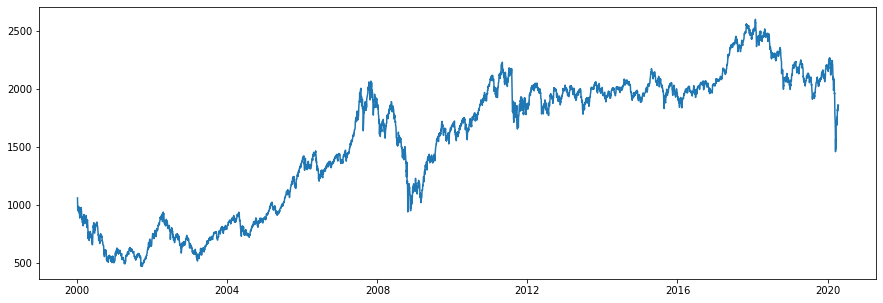

In [ ]:
# 원본 데이터 보기
plt.figure(figsize = (15, 5))
plt.plot(dataset2)
plt.show()

In [ ]:
# 필요한 부분만 불러오기
dataset = dataset.iloc[:, 1:2].values  

In [ ]:
dataset

array([[1059.04],
       [ 986.31],
       [ 960.79],
       ...,
       [1825.76],
       [1857.08],
       [1857.07]])

In [ ]:
# scikit-learn 라이브러리 의 MinMaxScaler 전처리 클래스를 사용하여 데이터 세트를 쉽게 정규화.
# MinMaxScaler을 통해 데이터를 비례적으로 조정

scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)

In [ ]:
dataset

array([[-0.44559812],
       [-0.51390748],
       [-0.53787633],
       ...,
       [ 0.27451947],
       [ 0.3039358 ],
       [ 0.3039264 ]])

In [ ]:
data_df = pd.DataFrame(dataset, columns=['price'], index=index)
data_df.head()

,price
Date,
2000-01-04,-0.445598
2000-01-05,-0.513907
2000-01-06,-0.537876
2000-01-07,-0.549278
2000-01-10,-0.513034


### 데이터 분할

In [ ]:
row = int(round(dataset.shape[0] * 0.9))
train_df = data_df[:row]
test_df = data_df[row:]

In [ ]:
row

4509

In [ ]:
dataset

array([[-0.44559812],
       [-0.51390748],
       [-0.53787633],
       ...,
       [ 0.27451947],
       [ 0.3039358 ],
       [ 0.3039264 ]])

In [ ]:
#for s in range(1, 8):
#    train_df['shift_{}'.format(s)] = train_df['price'].shift(8-s)
#    test_df['shift_{}'.format(s)] = test_df['price'].shift(8-s)

#train_df.head(19)

In [ ]:
for s in range(1, 8):
    train_df['shift_{}'.format(s)] = train_df['price'].shift(s)
    test_df['shift_{}'.format(s)] = test_df['price'].shift(s)

train_df.head(19)

C:\Users\K.N.W\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\K.N.W\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,price,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7
Date,,,,,,,,
2000-01-04,-0.445598,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,-0.513907,-0.445598,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,-0.537876,-0.513907,-0.445598,NaN,NaN,NaN,NaN,NaN
2000-01-07,-0.549278,-0.537876,-0.513907,-0.445598,NaN,NaN,NaN,NaN
2000-01-10,-0.513034,-0.549278,-0.537876,-0.513907,-0.445598,NaN,NaN,NaN
2000-01-11,-0.518585,-0.513034,-0.549278,-0.537876,-0.513907,-0.445598,NaN,NaN
2000-01-12,-0.543305,-0.518585,-0.513034,-0.549278,-0.537876,-0.513907,-0.445598,NaN
2000-01-13,-0.547024,-0.543305,-0.518585,-0.513034,-0.549278,-0.537876,-0.513907,-0.445598
2000-01-14,-0.549861,-0.547024,-0.543305,-0.518585,-0.513034,-0.549278,-0.537876,-0.513907


In [ ]:
X_train = train_df.dropna().drop('price', axis=1)
y_train = train_df.dropna()[['price']]

X_test = test_df.dropna().drop('price', axis=1)
y_test = test_df.dropna()[['price']]

In [ ]:
X_train.head()

,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7
Date,,,,,,,
2000-01-13,-0.543305,-0.518585,-0.513034,-0.549278,-0.537876,-0.513907,-0.445598
2000-01-14,-0.547024,-0.543305,-0.518585,-0.513034,-0.549278,-0.537876,-0.513907
2000-01-17,-0.549861,-0.547024,-0.543305,-0.518585,-0.513034,-0.549278,-0.537876
2000-01-18,-0.516763,-0.549861,-0.547024,-0.543305,-0.518585,-0.513034,-0.549278
2000-01-19,-0.518397,-0.516763,-0.549861,-0.547024,-0.543305,-0.518585,-0.513034


In [ ]:
len(X_train)

4502

In [ ]:
len(X_test)

494

In [ ]:
y_train.head()

,price
Date,
2000-01-13,-0.547024
2000-01-14,-0.549861
2000-01-17,-0.516763
2000-01-18,-0.518397
2000-01-19,-0.558549


In [ ]:
X_train_values = X_train.values
X_test_values= X_test.values

y_train_values = y_train.values
y_test_values = y_test.values

print(X_train_values.shape)
print(X_train_values)
print(y_train_values.shape)
print(y_train_values)

(4502, 7)
[[-0.54330502 -0.51858479 -0.513034   ... -0.53787633 -0.51390748
  -0.44559812]
 [-0.54702432 -0.54330502 -0.51858479 ... -0.54927845 -0.53787633
  -0.51390748]
 [-0.54986076 -0.54702432 -0.54330502 ... -0.513034   -0.54927845
  -0.53787633]
 ...
 [ 0.83197381  0.862752    0.84868251 ...  0.90404005  0.89366168
   0.89417825]
 [ 0.84801567  0.83197381  0.862752   ...  0.82959759  0.90404005
   0.89366168]
 [ 0.85691946  0.84801567  0.83197381 ...  0.84868251  0.82959759
   0.90404005]]
(4502, 1)
[[-0.54702432]
 [-0.54986076]
 [-0.5167627 ]
 ...
 [ 0.84801567]
 [ 0.85691946]
 [ 0.85533218]]


In [ ]:
X_train_t = X_train_values.reshape(X_train_values.shape[0], X_train_values.shape[1], 1)
X_test_t = X_test_values.reshape(X_test_values.shape[0], X_test_values.shape[1], 1)

print("최종 LSTM DATA")
print(X_train_t.shape)
print(X_train_t)
print(y_train_values)

최종 LSTM DATA
(4502, 7, 1)
[[[-0.54330502]
  [-0.51858479]
  [-0.513034  ]
  ...
  [-0.53787633]
  [-0.51390748]
  [-0.44559812]]

 [[-0.54702432]
  [-0.54330502]
  [-0.51858479]
  ...
  [-0.54927845]
  [-0.53787633]
  [-0.51390748]]

 [[-0.54986076]
  [-0.54702432]
  [-0.54330502]
  ...
  [-0.513034  ]
  [-0.54927845]
  [-0.53787633]]

 ...

 [[ 0.83197381]
  [ 0.862752  ]
  [ 0.84868251]
  ...
  [ 0.90404005]
  [ 0.89366168]
  [ 0.89417825]]

 [[ 0.84801567]
  [ 0.83197381]
  [ 0.862752  ]
  ...
  [ 0.82959759]
  [ 0.90404005]
  [ 0.89366168]]

 [[ 0.85691946]
  [ 0.84801567]
  [ 0.83197381]
  ...
  [ 0.84868251]
  [ 0.82959759]
  [ 0.90404005]]]
[[-0.54702432]
 [-0.54986076]
 [-0.5167627 ]
 ...
 [ 0.84801567]
 [ 0.85691946]
 [ 0.85533218]]


## LSTM  Adaboost MODEL

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
def lstm_model():                                           
    # create model
    model = Sequential()
    #model.add(LSTM(256, return_sequences=False, input_shape=(7, 1)))
    #model.add(Dropout(0.2))
    model.add(LSTM(128, return_sequences=False, input_shape=(7, 1)))
    model.add(Dropout(0.5))
    #model.add(LSTM(64, return_sequences=False))
    model.add(Dense(1, kernel_initializer='normal', activation='tanh'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
lstm_model().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#예측기 만들기
ABL_estimator = KerasRegressor(build_fn = lstm_model, epochs=50, batch_size=30, verbose=1)

In [ ]:
boosted_lstm = AdaBoostRegressor(base_estimator= ABL_estimator, n_estimators=200, random_state=0) 

In [ ]:
#rescaled_train_X = X_train_t.reshape(X_train_t.shape[0],X_train_t.shape[1],1)

In [ ]:
#boosted_ann.fit(rescaled_train_X, y_train) #부사리선생님은 이거 사용

In [ ]:
boosted_lstm.fit(X_train_t, y_train)# scale your training data 

C:\Users\K.N.W\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/50
4502/4502 [==============================] - 2s 452us/step - loss: 0.0215
Epoch 2/50
4502/4502 [==============================] - 1s 275us/step - loss: 0.0036
Epoch 3/50
4502/4502 [==============================] - 2s 386us/step - loss: 0.0023
Epoch 4/50
4502/4502 [==============================] - 1s 289us/step - loss: 0.0021
Epoch 5/50
4502/4502 [==============================] - 1s 321us/step - loss: 0.0019
Epoch 6/50
4502/4502 [==============================] - 1s 301us/step - loss: 0.0019
Epoch 7/50
4502/4502 [==============================] - 1s 333us/step - loss: 0.0020
Epoch 8/50
4502/4502 [==============================] - 1s 313us/step - loss: 0.0019
Epoch 9/50
4502/4502 [==============================] - 1s 299us/step - loss: 0.0018
Epoch 10/50
4502/4502 [==============================] - 1s 309us/step - loss: 0.0021 0s
Epoch 11/50
4502/4502 [==============================] - 1s 323us/step - loss: 0.0018
Epoch 12/50
4502/4502 [==============================] - 2s 

4502/4502 [==============================] - 2s 350us/step - loss: 0.0029
Epoch 39/50
4502/4502 [==============================] - 1s 291us/step - loss: 0.0029
Epoch 40/50
4502/4502 [==============================] - 2s 351us/step - loss: 0.0027
Epoch 41/50
4502/4502 [==============================] - 1s 305us/step - loss: 0.0029
Epoch 42/50
4502/4502 [==============================] - 2s 365us/step - loss: 0.0029 0s - loss: 0.00
Epoch 43/50
4502/4502 [==============================] - 1s 326us/step - loss: 0.0029
Epoch 44/50
4502/4502 [==============================] - 2s 365us/step - loss: 0.0028
Epoch 45/50
4502/4502 [==============================] - 1s 301us/step - loss: 0.0028
Epoch 46/50
4502/4502 [==============================] - 1s 327us/step - loss: 0.0026
Epoch 47/50
4502/4502 [==============================] - 1s 305us/step - loss: 0.0028
Epoch 48/50
4502/4502 [==============================] - 2s 346us/step - loss: 0.0027
Epoch 49/50
4502/4502 [===========================

4502/4502 [==============================] - 1s 288us/step - loss: 0.0062
Epoch 25/50
4502/4502 [==============================] - 1s 276us/step - loss: 0.0059
Epoch 26/50
4502/4502 [==============================] - 1s 295us/step - loss: 0.0063
Epoch 27/50
4502/4502 [==============================] - 1s 269us/step - loss: 0.0061
Epoch 28/50
4502/4502 [==============================] - 1s 264us/step - loss: 0.0059
Epoch 29/50
4502/4502 [==============================] - 1s 318us/step - loss: 0.0062
Epoch 30/50
4502/4502 [==============================] - 1s 262us/step - loss: 0.0061
Epoch 31/50
4502/4502 [==============================] - 1s 294us/step - loss: 0.0060
Epoch 32/50
4502/4502 [==============================] - 1s 278us/step - loss: 0.0060
Epoch 33/50
4502/4502 [==============================] - 1s 289us/step - loss: 0.0060
Epoch 34/50
4502/4502 [==============================] - 1s 276us/step - loss: 0.0062
Epoch 35/50
4502/4502 [==============================] - 1s 285us/

4502/4502 [==============================] - 1s 305us/step - loss: 0.0074
Epoch 19/50
4502/4502 [==============================] - 1s 265us/step - loss: 0.0071
Epoch 20/50
4502/4502 [==============================] - 1s 268us/step - loss: 0.0073
Epoch 21/50
4502/4502 [==============================] - 1s 317us/step - loss: 0.0072
Epoch 22/50
4502/4502 [==============================] - 1s 276us/step - loss: 0.0070
Epoch 23/50
4502/4502 [==============================] - 1s 297us/step - loss: 0.0072
Epoch 24/50
4502/4502 [==============================] - 1s 263us/step - loss: 0.0071
Epoch 25/50
4502/4502 [==============================] - 1s 331us/step - loss: 0.0070
Epoch 26/50
4502/4502 [==============================] - 1s 256us/step - loss: 0.0069
Epoch 27/50
4502/4502 [==============================] - 2s 334us/step - loss: 0.0072
Epoch 28/50
4502/4502 [==============================] - 1s 273us/step - loss: 0.0072
Epoch 29/50
4502/4502 [==============================] - 1s 306us/

AdaBoostRegressor(base_estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000002A0B263A288>,
                  learning_rate=1.0, loss='linear', n_estimators=200,
                  random_state=0)

In [ ]:
start = time.time()
y_pred = boosted_lstm.predict(X_test_t)
end = time.time()
total = end-start

print(total)

494/494 [==============================] - 0s 188us/step
0.8934891223907471


In [ ]:
y_pred = pd.DataFrame(y_pred, columns = ["price"], index = y_test.index)

In [ ]:
testPredict = scaler.inverse_transform(y_pred)
Ydata = scaler.inverse_transform(y_test)

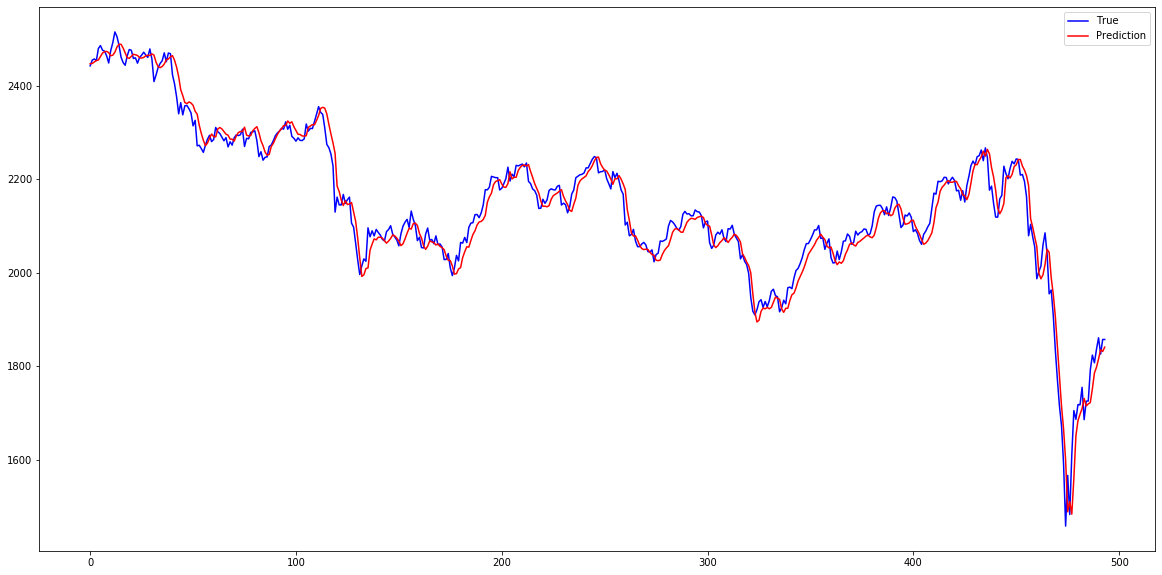

In [ ]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(Ydata, label='True', color = 'Blue')
ax.plot(testPredict, label='Prediction', color='Red')
ax.legend()
plt.show()

In [ ]:
mae = mean_absolute_error(scaler.inverse_transform(y_pred),scaler.inverse_transform(y_test))
mse = mean_squared_error(scaler.inverse_transform(y_pred),scaler.inverse_transform(y_test))
rmse = np.sqrt(mse)

In [ ]:
print('MAE: ', mae)
print('MSE: ', mse)
print('RMSE: ', rmse)

MAE:  22.013884336649156
MSE:  883.9851470149599
RMSE:  29.73188771361415


# 일반 LSTM 모형

In [ ]:
model = Sequential()

model.add(LSTM(128, return_sequences=False, input_shape=(7, 1)))
model.add(Dropout(0.5))
model.add(Dense(1, kernel_initializer='normal', activation='tanh'))
    
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 128)               66560     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
start = time.time()
model.fit(X_train_t, y_train, batch_size = 30, epochs = 50)
end = time.time()
total = end-start

print(total)

Epoch 1/50
4502/4502 [==============================] - 2s 428us/step - loss: 0.0307
Epoch 2/50
4502/4502 [==============================] - 1s 297us/step - loss: 0.0040
Epoch 3/50
4502/4502 [==============================] - 1s 307us/step - loss: 0.0023
Epoch 4/50
4502/4502 [==============================] - 1s 261us/step - loss: 0.0021
Epoch 5/50
4502/4502 [==============================] - 1s 301us/step - loss: 0.0020
Epoch 6/50
4502/4502 [==============================] - 1s 307us/step - loss: 0.0020
Epoch 7/50
4502/4502 [==============================] - 1s 296us/step - loss: 0.0019
Epoch 8/50
4502/4502 [==============================] - 1s 282us/step - loss: 0.0019
Epoch 9/50
4502/4502 [==============================] - 1s 313us/step - loss: 0.0019
Epoch 10/50
4502/4502 [==============================] - 1s 298us/step - loss: 0.0019
Epoch 11/50
4502/4502 [==============================] - 2s 346us/step - loss: 0.0019 0s - loss: 
Epoch 12/50
4502/4502 [============================

<function matplotlib.pyplot.show(*args, **kw)>

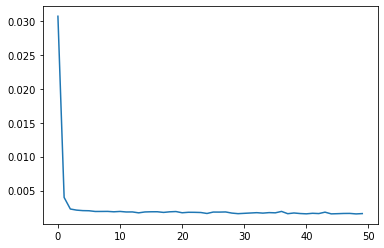

In [ ]:
plt.plot(model.history.history['loss'])
plt.show

In [ ]:
y_pred = model.predict(X_test_t)
y_pred = pd.DataFrame(y_pred, columns = ["price"], index = y_test.index)

In [ ]:
testPredict = scaler.inverse_transform(y_pred)
Ydata = scaler.inverse_transform(y_test)

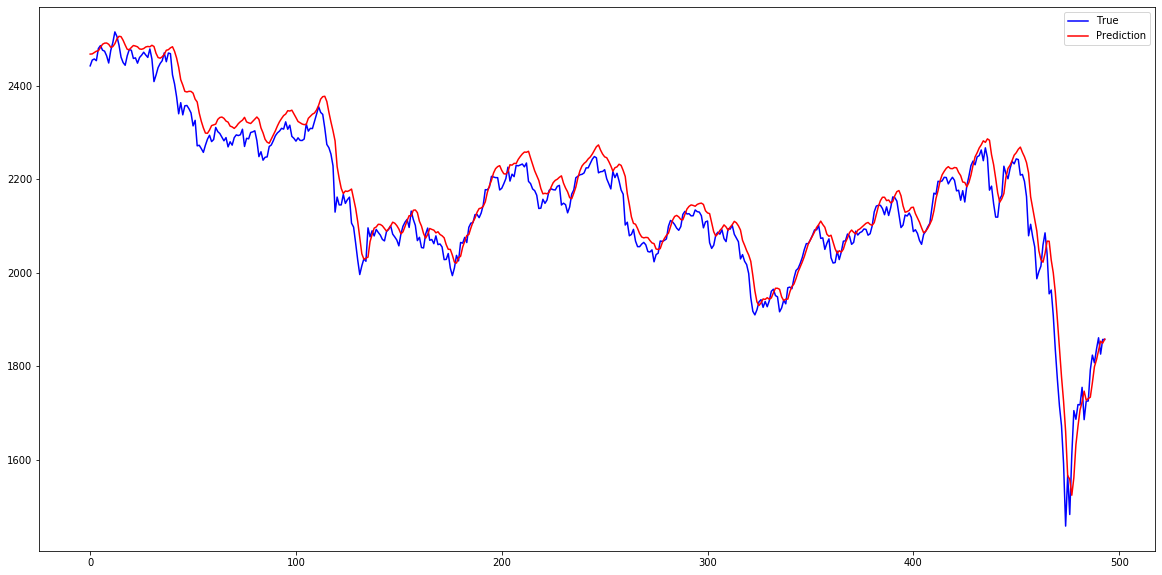

In [ ]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(Ydata, label='True', color='Blue')
ax.plot(testPredict, label='Prediction', color='Red')
ax.legend()
plt.show()

In [ ]:
mae = mean_absolute_error(scaler.inverse_transform(y_pred),scaler.inverse_transform(y_test))
mse = mean_squared_error(scaler.inverse_transform(y_pred),scaler.inverse_transform(y_test))
rmse = np.sqrt(mse)

In [ ]:
print('MAE: ', mae)
print('MSE: ', mse)
print('RMSE: ', rmse)

MAE:  29.37606035116712
MSE:  1569.6496719023396
RMSE:  39.618804523891676


## Adaboost-GRU MODEL

In [ ]:
def gru_model():                                           
    # create model
    model = Sequential()
    model.add(GRU(128, return_sequences=False, input_shape=(7, 1)))
    model.add(Dropout(0.5))
    model.add(Dense(1, kernel_initializer='normal', activation='tanh'))
    
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
gru_model().summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 128)               49920     
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 129       
Total params: 50,049
Trainable params: 50,049
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#예측기 만들기
ABL_estimator = KerasRegressor(build_fn = gru_model, epochs=50, batch_size=30, verbose=1)

In [ ]:
boosted_gru = AdaBoostRegressor(base_estimator= ABL_estimator, n_estimators=200, random_state=0) #

In [ ]:
boosted_gru.fit(X_train_t, y_train)# scale your training data 

C:\Users\K.N.W\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/50
4502/4502 [==============================] - 2s 511us/step - loss: 0.0261
Epoch 2/50
4502/4502 [==============================] - 2s 389us/step - loss: 0.0048
Epoch 3/50
4502/4502 [==============================] - 1s 322us/step - loss: 0.0038
Epoch 4/50
4502/4502 [==============================] - 2s 378us/step - loss: 0.0025
Epoch 5/50
4502/4502 [==============================] - 1s 322us/step - loss: 0.0022
Epoch 6/50
4502/4502 [==============================] - 1s 295us/step - loss: 0.0022
Epoch 7/50
4502/4502 [==============================] - 1s 295us/step - loss: 0.0023
Epoch 8/50
4502/4502 [==============================] - 1s 321us/step - loss: 0.0020
Epoch 9/50
4502/4502 [==============================] - 1s 289us/step - loss: 0.0020
Epoch 10/50
4502/4502 [==============================] - 1s 282us/step - loss: 0.0020
Epoch 11/50
4502/4502 [==============================] - 1s 283us/step - loss: 0.0020
Epoch 12/50
4502/4502 [==============================] - 1s 316

4502/4502 [==============================] - 2s 370us/step - loss: 0.0026
Epoch 38/50
4502/4502 [==============================] - 2s 384us/step - loss: 0.0026
Epoch 39/50
4502/4502 [==============================] - 2s 389us/step - loss: 0.0025
Epoch 40/50
4502/4502 [==============================] - 2s 421us/step - loss: 0.0024
Epoch 41/50
4502/4502 [==============================] - 2s 408us/step - loss: 0.0026
Epoch 42/50
4502/4502 [==============================] - 2s 387us/step - loss: 0.0026
Epoch 43/50
4502/4502 [==============================] - 2s 389us/step - loss: 0.0024
Epoch 44/50
4502/4502 [==============================] - 2s 452us/step - loss: 0.0026 0s - 
Epoch 45/50
4502/4502 [==============================] - 2s 456us/step - loss: 0.0025
Epoch 46/50
4502/4502 [==============================] - 2s 417us/step - loss: 0.0024
Epoch 47/50
4502/4502 [==============================] - 2s 414us/step - loss: 0.0024
Epoch 48/50
4502/4502 [==============================] - 2s 

4502/4502 [==============================] - 2s 353us/step - loss: 0.0061
Epoch 25/50
4502/4502 [==============================] - 2s 380us/step - loss: 0.0058
Epoch 26/50
4502/4502 [==============================] - 1s 323us/step - loss: 0.0058
Epoch 27/50
4502/4502 [==============================] - 2s 363us/step - loss: 0.0058
Epoch 28/50
4502/4502 [==============================] - 2s 396us/step - loss: 0.0053 0s - loss: 0
Epoch 29/50
4502/4502 [==============================] - 2s 366us/step - loss: 0.0055
Epoch 30/50
4502/4502 [==============================] - 1s 310us/step - loss: 0.0052
Epoch 31/50
4502/4502 [==============================] - 2s 353us/step - loss: 0.0054
Epoch 32/50
4502/4502 [==============================] - 1s 309us/step - loss: 0.0053
Epoch 33/50
4502/4502 [==============================] - 1s 330us/step - loss: 0.0053
Epoch 34/50
4502/4502 [==============================] - 1s 306us/step - loss: 0.0055
Epoch 35/50
4502/4502 [==============================

4502/4502 [==============================] - 1s 298us/step - loss: 0.0072
Epoch 10/50
4502/4502 [==============================] - 1s 306us/step - loss: 0.0074
Epoch 11/50
4502/4502 [==============================] - 1s 320us/step - loss: 0.0071
Epoch 12/50
4502/4502 [==============================] - 1s 300us/step - loss: 0.0072
Epoch 13/50
4502/4502 [==============================] - 1s 309us/step - loss: 0.0067
Epoch 14/50
4502/4502 [==============================] - 1s 330us/step - loss: 0.0070
Epoch 15/50
4502/4502 [==============================] - 1s 321us/step - loss: 0.0070
Epoch 16/50
4502/4502 [==============================] - 1s 310us/step - loss: 0.0069
Epoch 17/50
4502/4502 [==============================] - 1s 286us/step - loss: 0.0067
Epoch 18/50
4502/4502 [==============================] - 1s 327us/step - loss: 0.0066
Epoch 19/50
4502/4502 [==============================] - 1s 329us/step - loss: 0.0067
Epoch 20/50
4502/4502 [==============================] - 1s 315us/

4502/4502 [==============================] - 2s 357us/step - loss: 0.0095
Epoch 3/50
4502/4502 [==============================] - 2s 348us/step - loss: 0.0082
Epoch 4/50
4502/4502 [==============================] - 2s 335us/step - loss: 0.0076
Epoch 5/50
4502/4502 [==============================] - 2s 388us/step - loss: 0.0075
Epoch 6/50
4502/4502 [==============================] - 2s 484us/step - loss: 0.0074
Epoch 7/50
4502/4502 [==============================] - 2s 407us/step - loss: 0.0073
Epoch 8/50
4502/4502 [==============================] - 2s 386us/step - loss: 0.0072
Epoch 9/50
4502/4502 [==============================] - 2s 472us/step - loss: 0.0072
Epoch 10/50
4502/4502 [==============================] - 2s 428us/step - loss: 0.0073
Epoch 11/50
4502/4502 [==============================] - 2s 390us/step - loss: 0.0072
Epoch 12/50
4502/4502 [==============================] - 2s 430us/step - loss: 0.0072
Epoch 13/50
4502/4502 [==============================] - 2s 397us/step - 

AdaBoostRegressor(base_estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x000002A0FF7E3508>,
                  learning_rate=1.0, loss='linear', n_estimators=200,
                  random_state=0)

In [ ]:
start = time.time()
y_pred = boosted_gru.predict(X_test_t)
end = time.time()
total = end-start

print(total)

494/494 [==============================] - 0s 71us/step
0.4687325954437256


In [ ]:
y_pred = pd.DataFrame(y_pred, columns = ["price"], index = y_test.index)

In [ ]:
testPredict = scaler.inverse_transform(y_pred)
Ydata = scaler.inverse_transform(y_test)

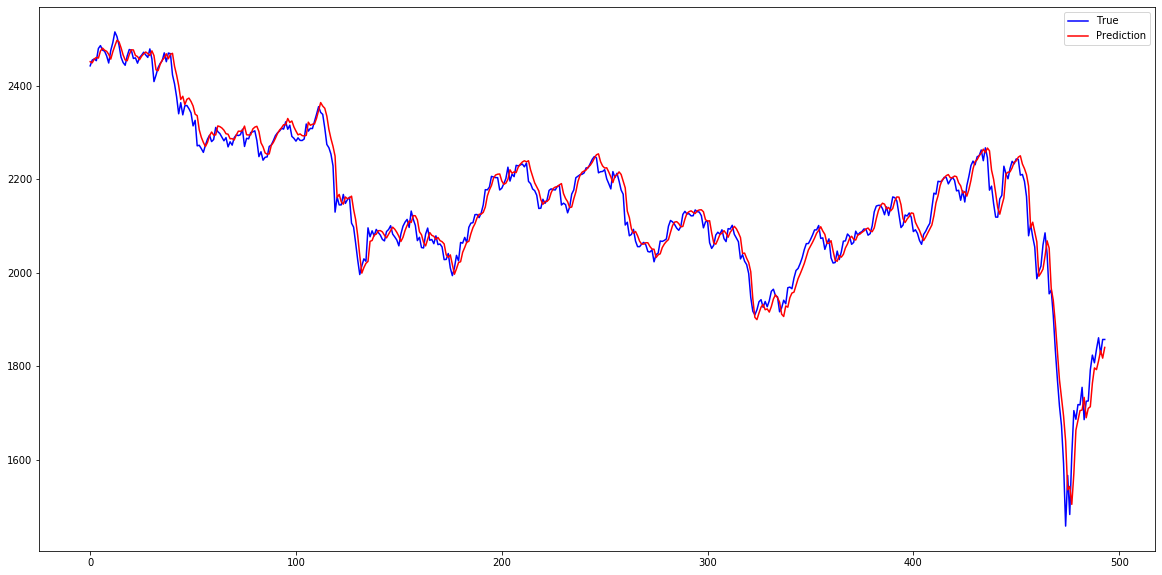

In [ ]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(Ydata, label='True', color = 'Blue')
ax.plot(testPredict, label='Prediction', color='Red')
ax.legend()
plt.show()

In [ ]:
mae = mean_absolute_error(scaler.inverse_transform(y_pred),scaler.inverse_transform(y_test))
mse = mean_squared_error(scaler.inverse_transform(y_pred),scaler.inverse_transform(y_test))
rmse = np.sqrt(mse)

In [ ]:
print('MAE: ', mae)
print('MSE: ', mse)
print('RMSE: ', rmse)

MAE:  19.648382523880304
MSE:  777.7995888724099
RMSE:  27.88905858705901


## 일반 GRU 모델

In [ ]:
model = Sequential()

model.add(GRU(128, return_sequences=False, input_shape=(7, 1)))
model.add(Dropout(0.5))
model.add(Dense(1, kernel_initializer='normal', activation='tanh'))
    
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_16 (GRU)                 (None, 128)               49920     
_________________________________________________________________
dropout_30 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 129       
Total params: 50,049
Trainable params: 50,049
Non-trainable params: 0
_________________________________________________________________


In [ ]:
start = time.time()
model.fit(X_train_t, y_train, batch_size = 30, epochs = 50)
end = time.time()
total = end-start

print(total)

Epoch 1/50
4502/4502 [==============================] - 2s 470us/step - loss: 0.0225
Epoch 2/50
4502/4502 [==============================] - 2s 349us/step - loss: 0.0048
Epoch 3/50
4502/4502 [==============================] - 2s 344us/step - loss: 0.0040
Epoch 4/50
4502/4502 [==============================] - 2s 405us/step - loss: 0.0026
Epoch 5/50
4502/4502 [==============================] - 2s 404us/step - loss: 0.0024
Epoch 6/50
4502/4502 [==============================] - 2s 418us/step - loss: 0.0022
Epoch 7/50
4502/4502 [==============================] - 2s 455us/step - loss: 0.0021
Epoch 8/50
4502/4502 [==============================] - 2s 394us/step - loss: 0.0020
Epoch 9/50
4502/4502 [==============================] - 2s 440us/step - loss: 0.0021
Epoch 10/50
4502/4502 [==============================] - 2s 386us/step - loss: 0.0020
Epoch 11/50
4502/4502 [==============================] - 2s 392us/step - loss: 0.0019
Epoch 12/50
4502/4502 [==============================] - 2s 367

<function matplotlib.pyplot.show(*args, **kw)>

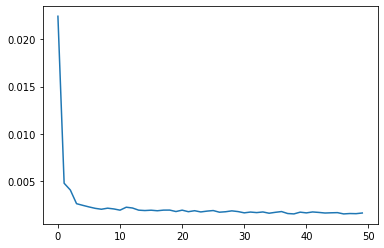

In [ ]:
plt.plot(model.history.history['loss'])
plt.show

In [ ]:
y_pred = model.predict(X_test_t)
y_pred = pd.DataFrame(y_pred, columns = ["price"], index = y_test.index)

In [ ]:
testPredict = scaler.inverse_transform(y_pred)
Ydata = scaler.inverse_transform(y_test)

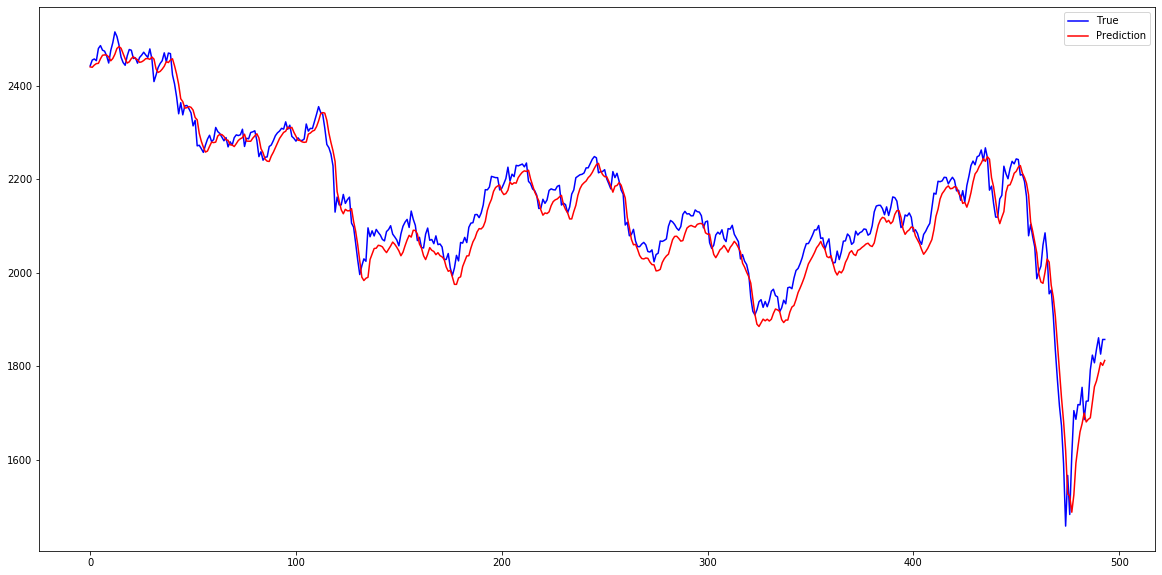

In [ ]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(Ydata, label='True', color = 'Blue')
ax.plot(testPredict, label='Prediction', color='Red')
ax.legend()
plt.show()

In [ ]:
mae = mean_absolute_error(scaler.inverse_transform(y_pred),scaler.inverse_transform(y_test))
mse = mean_squared_error(scaler.inverse_transform(y_pred),scaler.inverse_transform(y_test))
rmse = np.sqrt(mse)

In [ ]:
print('MAE: ', mae)
print('MSE: ', mse)
print('RMSE: ', rmse)

MAE:  29.155274554418643
MSE:  1366.3158837724989
RMSE:  36.96371036263133
